# import libraries and packages

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers, optimizers

import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seed for reproducibility
torch.manual_seed(0)
tf.random.set_seed(0)

# Load the MNIST dataset from pytorch and tensorflow


## From PyTorch


In [ ]:
# Define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset for PyTorch
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split the training set into training and validation sets
train_dataset, valid_dataset = random_split(train_dataset, [50000, 10000])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## From Tensorflow

In [ ]:
# Load the MNIST dataset for TensorFlow
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert the labels to one-hot encoded vectors
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Split the training set into training and validation sets
train_images, valid_images = train_images[:50000], train_images[50000:]
train_labels, valid_labels = train_labels[:50000], train_labels[50000:]

11490434/11490434 [==============================] - 2s 0us/step


# Build and define the models (MLP, CNN)

## MLP

In [ ]:
# Define model architecture for PyTorch
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        x = nn.functional.softmax(x, dim=1)
        return x

In [ ]:
# Define the model architecture for TensorFlow
mlp_tf = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

## CNN

In [ ]:
# Define model architecture for PyTorch
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x

In [ ]:
# Define the model architecture for TensorFlow
cnn_tf = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Train & Evaluate

## Set the parameters for training (batch size, the number of epochs, and learning rate)

In [ ]:
batchsize = 256
epochs = 10
lr = 0.001

## pytorch 

- need to write more code to specify the details of the training loop, such as the forward and backward passes through the network, the optimization algorithm, and the data loading and batching. 


### write the util functions (score function, train function)

In [ ]:
# Define the score function to calculate accuracy
def score(model, data_loader, criterion=None, verbose=True):
    loss, correct = 0.0, 0
    model.eval()

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            if criterion is not None:
                loss += criterion(output, target).item()
            correct += (output.argmax(dim=1) == target).sum().item()
    if criterion is not None:
        loss /= len(data_loader.dataset)
    acc = correct / len(data_loader.dataset)
    
    if verbose:
        print('Average Loss: {:.6f}, Accuracy: {:.2f}%'.format(loss, acc*100))
        
    return loss, acc

In [ ]:
def train(model, train_loader, valid_loader, optimizer, criterion, num_epochs=10, verbose=True):
    train_loss_list, valid_loss_list, train_acc_list, valid_acc_list = [], [], [], []
    best_valid_loss = float('inf')
    
    for epoch in range(num_epochs):
        train_loss, train_correct = 0, 0
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            train_loss += loss.item()
            train_correct += (output.argmax(dim=1) == target).sum().item()
            loss.backward()
            optimizer.step()

            if verbose and (batch_idx % 100 == 0):
                print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx*len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()), end = '')
                
        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
                
        model.eval()
        valid_loss, valid_acc = score(model, valid_loader, criterion, verbose=False)
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_model.pth')
            
        if verbose:
            print('\rEpoch: {} Train Loss: {:.6f}, Train Accuracy: {:.2f}%, Validation Loss: {:.6f}, Validation Accuracy: {:.2f}%'.format(
                epoch+1, train_loss, train_acc*100, valid_loss, valid_acc*100))

    return model, {'loss':train_loss_list, 'val_loss':valid_loss_list, 'accuracy':train_acc_list, 'val_accuracy':valid_acc_list}

### Train


#### Define the dataloader with batchsize

In [ ]:
# Define data loaders for PyTorch
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batchsize, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

criterion_torch = nn.CrossEntropyLoss()

#### Training

In [ ]:
mlp_torch = MLP().to(device)
optimizer_mlp_torch = optim.Adam(mlp_torch.parameters(), lr=lr)
mlp_torch, mlp_torch_history = train(mlp_torch, train_loader, valid_loader, optimizer_mlp_torch, criterion_torch, num_epochs=epochs)

Epoch: 1 Train Loss: 0.024678, Train Accuracy: 89.09%, Validation Loss: 0.023937, Validation Accuracy: 93.88%
Epoch: 2 Train Loss: 0.023696, Train Accuracy: 94.76%, Validation Loss: 0.023718, Validation Accuracy: 95.13%
Epoch: 3 Train Loss: 0.023498, Train Accuracy: 96.00%, Validation Loss: 0.023669, Validation Accuracy: 95.40%
Epoch: 4 Train Loss: 0.023406, Train Accuracy: 96.51%, Validation Loss: 0.023586, Validation Accuracy: 95.93%
Epoch: 5 Train Loss: 0.023356, Train Accuracy: 96.80%, Validation Loss: 0.023524, Validation Accuracy: 96.32%
Epoch: 6 Train Loss: 0.023302, Train Accuracy: 97.19%, Validation Loss: 0.023430, Validation Accuracy: 96.83%
Epoch: 7 Train Loss: 0.023264, Train Accuracy: 97.41%, Validation Loss: 0.023697, Validation Accuracy: 95.15%
Epoch: 8 Train Loss: 0.023260, Train Accuracy: 97.38%, Validation Loss: 0.023408, Validation Accuracy: 97.02%
Epoch: 9 Train Loss: 0.023209, Train Accuracy: 97.74%, Validation Loss: 0.023530, Validation Accuracy: 96.22%
Epoch: 10 

In [ ]:
cnn_torch = CNN().to(device)
optimizer_cnn_torch = optim.Adam(cnn_torch.parameters(), lr=lr)
cnn_torch, cnn_torch_history = train(cnn_torch, train_loader, valid_loader, optimizer_cnn_torch, criterion_torch, num_epochs=epochs)

Epoch: 1 Train Loss: 0.002308, Train Accuracy: 95.40%, Validation Loss: 0.000930, Validation Accuracy: 98.30%
Epoch: 2 Train Loss: 0.000722, Train Accuracy: 98.62%, Validation Loss: 0.000680, Validation Accuracy: 98.77%
Epoch: 3 Train Loss: 0.000502, Train Accuracy: 98.96%, Validation Loss: 0.000673, Validation Accuracy: 98.68%
Epoch: 4 Train Loss: 0.000376, Train Accuracy: 99.22%, Validation Loss: 0.000524, Validation Accuracy: 99.14%
Epoch: 5 Train Loss: 0.000292, Train Accuracy: 99.35%, Validation Loss: 0.000601, Validation Accuracy: 98.84%
Epoch: 6 Train Loss: 0.000196, Train Accuracy: 99.59%, Validation Loss: 0.000559, Validation Accuracy: 98.98%
Epoch: 7 Train Loss: 0.000178, Train Accuracy: 99.64%, Validation Loss: 0.000511, Validation Accuracy: 99.14%
Epoch: 8 Train Loss: 0.000162, Train Accuracy: 99.65%, Validation Loss: 0.000617, Validation Accuracy: 99.01%
Epoch: 9 Train Loss: 0.000124, Train Accuracy: 99.72%, Validation Loss: 0.000689, Validation Accuracy: 98.85%
Epoch: 10 

### Evaluate

In [ ]:
test_loss_mlp_torch, test_acc_mlp_torch = score(mlp_torch, test_loader, criterion_torch, verbose = False)
test_loss_cnn_torch, test_acc_cnn_torch = score(cnn_torch, test_loader, criterion_torch, verbose = False)
print(f'Test Accuracy (mlp_torch): {test_acc_mlp_torch*100:.2f}%')
print(f'Test Accuracy (cnn_torch): {test_acc_cnn_torch*100:.2f}%')

Test Accuracy (mlp_torch): 96.81%
Test Accuracy (cnn_torch): 98.94%


## Tensorflow (no need the util functions)

In [ ]:
mlp_tf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_tf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train (fit)

In [ ]:
# Train the TensorFlow model for a specified number of epochs
mlp_tf_history = mlp_tf.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=epochs, batch_size=batchsize)

Epoch 1/10
782/782 [==============================] - 5s 4ms/step - loss: 0.2594 - accuracy: 0.9227 - val_loss: 0.1210 - val_accuracy: 0.9651
Epoch 2/10
782/782 [==============================] - 3s 4ms/step - loss: 0.1016 - accuracy: 0.9690 - val_loss: 0.0921 - val_accuracy: 0.9713
Epoch 3/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0658 - accuracy: 0.9797 - val_loss: 0.0880 - val_accuracy: 0.9725
Epoch 4/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0472 - accuracy: 0.9854 - val_loss: 0.0821 - val_accuracy: 0.9760
Epoch 5/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0352 - accuracy: 0.9877 - val_loss: 0.0889 - val_accuracy: 0.9755
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0301 - accuracy: 0.9900 - val_loss: 0.0921 - val_accuracy: 0.9744
Epoch 7/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0199 - accuracy: 0.9934 - val_loss: 0.1038 - val_accuracy: 0.9734
Epoch 

In [ ]:
cnn_tf_history = cnn_tf.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), epochs=epochs, batch_size=batchsize)

Epoch 1/10
782/782 [==============================] - 7s 6ms/step - loss: 0.1781 - accuracy: 0.9463 - val_loss: 0.0604 - val_accuracy: 0.9833
Epoch 2/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0536 - accuracy: 0.9833 - val_loss: 0.0453 - val_accuracy: 0.9880
Epoch 3/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0350 - accuracy: 0.9890 - val_loss: 0.0375 - val_accuracy: 0.9895
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0264 - accuracy: 0.9913 - val_loss: 0.0365 - val_accuracy: 0.9890
Epoch 5/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0194 - accuracy: 0.9937 - val_loss: 0.0392 - val_accuracy: 0.9901
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0162 - accuracy: 0.9949 - val_loss: 0.0378 - val_accuracy: 0.9909
Epoch 7/10
782/782 [==============================] - 4s 6ms/step - loss: 0.0126 - accuracy: 0.9957 - val_loss: 0.0384 - val_accuracy: 0.9911
Epoch 

### Evaluate

In [ ]:
# Evaluate the TensorFlow model on the test set
test_loss_tf, test_acc_mlp_tf = mlp_tf.evaluate(test_images, test_labels, verbose=0)
test_loss_tf, test_acc_cnn_tf = cnn_tf.evaluate(test_images, test_labels, verbose=0)
print(f'Test Accuracy (mlp_tf): {test_acc_mlp_tf*100:.2f}%')
print(f'Test Accuracy (cnn_tf): {test_acc_cnn_tf*100:.2f}%')

Test Accuracy (mlp_tf): 98.11%
Test Accuracy (cnn_tf): 99.14%


# Make the result plots (loss & accuracy)

In [ ]:
def make_plots(history):
    plt.figure(figsize=(12,3))
    plt.subplot(1,2,1)
    plt.plot(history['loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history['accuracy'], label='Train')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

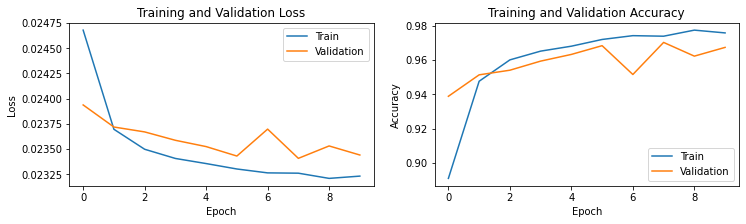

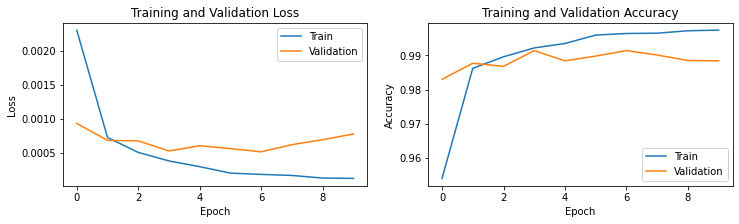

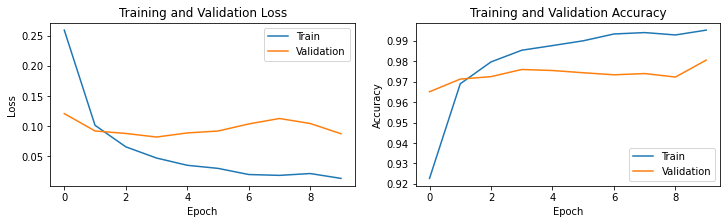

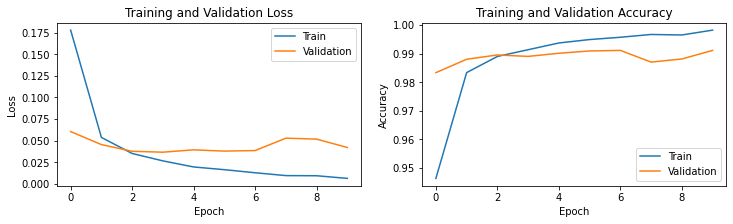

In [ ]:
make_plots(mlp_torch_history)
make_plots(cnn_torch_history)
make_plots(mlp_tf_history.history)
make_plots(cnn_tf_history.history)